In [ ]:
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00389/DevanagariHandwrittenCharacterDataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 76.6M  100 76.6M    0     0  39.2M      0  0:00:01  0:00:01 --:--:-- 39.2M


In [ ]:
!unzip DevanagariHandwrittenCharacterDataset.zip

In [ ]:
from glob import glob
files=glob('/content/DevanagariHandwrittenCharacterDataset/*/*/*')

In [ ]:
len(files)

92000

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from tqdm.notebook import tqdm,trange

In [ ]:
hi_chars=[]
for i in tqdm(files):
    img=np.array(Image.open(i),dtype=np.uint8).reshape(32,32,1)
    rho=random.randint(0,30)
    rwo=random.randint(0,30)
    img=tf.image.pad_to_bounding_box(img,rho,rwo,64,64)
    img=255-np.array(img,dtype=np.uint8)
    hi_chars.append(img)
hi_chars=np.array(hi_chars,dtype=np.uint8)
hi_chars=np.concatenate((hi_chars,hi_chars),axis=0)

  0%|          | 0/92000 [00:00<?, ?it/s]

In [ ]:
hi_chars.shape

(184000, 64, 64, 1)

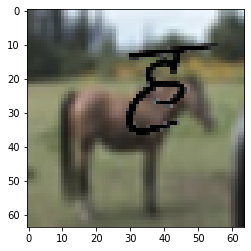

In [ ]:
plt.imshow(cifar_xt[59999])

In [ ]:
(xt,_), (xtt,_)=cifar10.load_data()
xt=np.concatenate((xt,xtt),axis=0)
cifar_xt=[]
for i in xt:
    img=Image.fromarray(i)
    img=img.resize((64,64))
    cifar_xt.append(np.array(img,dtype=np.uint8))
xt=0
cifar_xt=np.array(cifar_xt,dtype=np.uint8)
cifar_xt=np.concatenate((cifar_xt,cifar_xt,cifar_xt),axis=0)

In [ ]:
cifar_xt.shape

(120000, 64, 64, 3)

In [ ]:
##  Dataset  for classifiction
(xt,_), (xtt,_)=cifar10.load_data()
xt=np.concatenate((xt,xtt),axis=0)
cifar_xt=[]
for i in xt:
    img=Image.fromarray(i)
    img=img.resize((64,64))
    cifar_xt.append(np.array(img,dtype=np.uint8))
xt=0
cifar_xt=np.array(cifar_xt,dtype=np.uint8)
cifar_xt=np.concatenate((cifar_xt,cifar_xt),axis=0)

In [ ]:
## classification dataset

In [ ]:
def fusion(base_image,overlay_image):
    for i in range(64):
        for j in range(64):
            if(overlay_image[i,j])<120:
                base_image[i,j]=overlay_image[i,j]
    return base_image

In [ ]:
##  Dataset for classification
cifar_xt[:60000]=np.array([fusion(cifar_xt[i],hi_chars[i]) for i in trange(60000)],dtype=np.uint8)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
yt=np.ones((60000,),dtype=np.uint8)
ytf=np.zeros((60000),dtype=np.uint8)
yt=np.concatenate((yt,ytf),axis=0)

In [ ]:
yt=yt.reshape(120000,1)

In [ ]:
yt[0]

array([1], dtype=uint8)

In [ ]:
def invert(base_image,overlay_image):
    for i in range(64):
        for j in range(64):
            if(overlay_image[i,j])<120:
                base_image[i,j]=overlay_image[i,j]
    return base_image,overlay_image

In [ ]:
def gen_dataset():
    for i in range(180000):
        yield invert(cifar_xt[i],hi_chars[i])

In [ ]:
dataset=tf.data.Dataset.from_generator(gen_dataset,(tf.uint8,tf.uint8))
dataset=dataset.repeat()
dataset=dataset.batch(256)

In [ ]:
def gen_classification_dataset():
    for i in range(120000):
        yield cifar_xt[i],yt[i]

In [ ]:
classification_dataset=tf.data.Dataset.from_generator(gen_classification_dataset,(tf.uint8,tf.uint8))
classification_dataset=classification_dataset.shuffle(120000)
classification_dataset=classification_dataset.repeat()
classification_dataset=classification_dataset.batch(256)

In [ ]:
def loss_fn(y_true,y_pred):
    y_true=tf.cast(y_true,tf.float32)
    y_pred=tf.cast(y_pred,tf.float32)
    ssim=tf.image.ssim(y_true,y_pred,max_val=255)
    y_t=tf.ones_like(ssim)
    return tf.keras.losses.mean_squared_error([y_t],[ssim])

In [ ]:
def metric_fn(y_true,y_pred):
    return tf.math.reduce_mean([tf.image.ssim(y_true,y_pred,max_val=255)],axis=-1)

In [ ]:
inp=tf.keras.Input((64,64,3))
#x=tf.keras.layers.Resizing(64,64)(inp)
x=tf.keras.layers.Lambda(tf.image.rgb_to_grayscale)(inp)
x=tf.keras.layers.Rescaling(scale=1./255)(x)
# (?,64,64,1)
x_64es1 = tf.keras.layers.Conv2D(8,(3,1),activation=tf.nn.leaky_relu,padding='same')(x)
x_64es1 = tf.keras.layers.BatchNormalization()(x_64es1)
x_64es2 = tf.keras.layers.Conv2D(8,(1,5),activation=tf.nn.leaky_relu,padding='same')(x)
x_64es2 = tf.keras.layers.BatchNormalization()(x_64es2)
x_64e = tf.keras.layers.Conv2D(8, (3, 3), activation=tf.nn.leaky_relu, padding='same')(tf.keras.layers.concatenate([x,x_64es1,x_64es2]))
x_64e = tf.keras.layers.BatchNormalization()(x_64e)
# (?,64,64,8)
x_32p = tf.keras.layers.AvgPool2D((2, 2), padding='same')(x_64e)
# (?,32,32,8)
x_32es1 = tf.keras.layers.Conv2D(8,(3,1),activation=tf.nn.leaky_relu,padding='same')(x_32p)
x_32es1 = tf.keras.layers.BatchNormalization()(x_32es1)
x_32es2 = tf.keras.layers.Conv2D(8,(1,5),activation=tf.nn.leaky_relu,padding='same')(x_32p)
x_32es2 = tf.keras.layers.BatchNormalization()(x_32es2)
x_32e = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.nn.leaky_relu, padding='same')(tf.keras.layers.concatenate([x_32p,x_32es1,x_32es2]))
x_32e = tf.keras.layers.BatchNormalization()(x_32e)
# (?,32,32,16)
x_16p = tf.keras.layers.AvgPool2D((2, 2), padding='same')(x_32e)
# (?,16,16,16)
x_16es1 = tf.keras.layers.Conv2D(8,(3,1),activation=tf.nn.leaky_relu,padding='same')(x_16p)
x_16es1 = tf.keras.layers.BatchNormalization()(x_16es1)
x_16es2 = tf.keras.layers.Conv2D(8,(1,5),activation=tf.nn.leaky_relu,padding='same')(x_16p)
x_16es2 = tf.keras.layers.BatchNormalization()(x_16es2)
x_16e = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.leaky_relu, padding='same')(tf.keras.layers.concatenate([x_16p,x_16es1,x_16es2]))
x_16e = tf.keras.layers.BatchNormalization()(x_16e)
# (?,16,16,32)
x_8p = tf.keras.layers.AvgPool2D((2, 2), padding='same')(x_16e)
# (?,8,8,32)
x_8e = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x_8p)
x_8e = tf.keras.layers.BatchNormalization()(x_8e)
# (?,8,8,64)
encoded = tf.keras.layers.AvgPool2D((2, 2), padding='same')(x_8e)
# (?,4,4,64)

x = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation=tf.nn.leaky_relu, padding='same')(encoded)
x = tf.keras.layers.BatchNormalization()(x)
# (?,4,4,32)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
# (?,8,8,32)
x = tf.keras.layers.Conv2DTranspose(16, (3, 3), activation=tf.nn.leaky_relu, padding='same')(tf.keras.layers.concatenate([x,x_8e]))
x = tf.keras.layers.BatchNormalization()(x)
# (?,8,8,16)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
# (?,16,16,16)
x = tf.keras.layers.Conv2DTranspose(8, (3, 3), activation=tf.nn.leaky_relu,padding='same')(tf.keras.layers.concatenate([x,x_16e,x_16es1,x_16es2]))
x = tf.keras.layers.BatchNormalization()(x)
# (?,16,16,8)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
# (?,32,32,8)
x = tf.keras.layers.Conv2DTranspose(1, (3, 3), activation=tf.nn.leaky_relu,padding='same')(tf.keras.layers.concatenate([x,x_32e,x_32es1,x_32es2]))
x = tf.keras.layers.BatchNormalization()(x)
# (?,32,32,1)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
# (?,64,64,1)
x = tf.keras.layers.Activation('sigmoid')(x)

out=tf.keras.layers.Rescaling(scale=255)(x)

model=tf.keras.Model(inputs=inp,outputs=out)
model.compile(optimizer='adam', loss=loss_fn,metrics=[metric_fn])

In [ ]:
model(np.expand_dims(cifar_xt[0],axis=0)).shape

TensorShape([1, 64, 64, 1])

In [ ]:
model.fit(dataset,epochs=30,steps_per_epoch=36)

Epoch 1/30
36/36 [==============================] - 98s 2s/step - loss: 0.3388 - metric_fn: 0.4265
Epoch 2/30
36/36 [==============================] - 67s 2s/step - loss: 0.1878 - metric_fn: 0.5684
Epoch 3/30
36/36 [==============================] - 65s 2s/step - loss: 0.1247 - metric_fn: 0.6499
Epoch 4/30
36/36 [==============================] - 66s 2s/step - loss: 0.0851 - metric_fn: 0.7111
Epoch 5/30
36/36 [==============================] - 66s 2s/step - loss: 0.0734 - metric_fn: 0.7320
Epoch 6/30
36/36 [==============================] - 67s 2s/step - loss: 0.0601 - metric_fn: 0.7572
Epoch 7/30
36/36 [==============================] - 66s 2s/step - loss: 0.0578 - metric_fn: 0.7619
Epoch 8/30
36/36 [==============================] - 66s 2s/step - loss: 0.0501 - metric_fn: 0.7782
Epoch 9/30
36/36 [==============================] - 66s 2s/step - loss: 0.0471 - metric_fn: 0.7850
Epoch 10/30
36/36 [==============================] - 66s 2s/step - loss: 0.0455 - metric_fn: 0.7886
Epoch 11/

In [ ]:
model.summary()

In [ ]:
tf.saved_model.save(model,'Autoenc/')

In [ ]:
model.trainable=False #Freeze weights of autoencoder

In [ ]:
inp=tf.keras.Input((64,64,3))
x=model(inp)
x=tf.keras.layers.Rescaling(scale=1./255)(x)
cx=tf.keras.layers.Rescaling(scale=1./255)(inp)
# (?,64,64,1)
x_64es1 = tf.keras.layers.Conv2D(8,(3,1),activation=tf.nn.leaky_relu,padding='same')(cx)
x_64es1 = tf.keras.layers.BatchNormalization()(x_64es1)
x_64es2 = tf.keras.layers.Conv2D(8,(1,5),activation=tf.nn.leaky_relu,padding='same')(cx)
x_64es2 = tf.keras.layers.BatchNormalization()(x_64es2)
x_64e = tf.keras.layers.Conv2D(8, (3, 3), activation=tf.nn.leaky_relu, padding='same')(tf.keras.layers.concatenate([x,x_64es1,x_64es2]))
x_64e = tf.keras.layers.BatchNormalization()(x_64e)
# (?,64,64,8)
x_32p = tf.keras.layers.AvgPool2D((2, 2), padding='same')(x_64e)
# (?,32,32,8)
x_32es1 = tf.keras.layers.Conv2D(8,(3,1),activation=tf.nn.leaky_relu,padding='same')(x_32p)
x_32es1 = tf.keras.layers.BatchNormalization()(x_32es1)
x_32es2 = tf.keras.layers.Conv2D(8,(1,5),activation=tf.nn.leaky_relu,padding='same')(x_32p)
x_32es2 = tf.keras.layers.BatchNormalization()(x_32es2)
x_32e = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.nn.leaky_relu, padding='same')(tf.keras.layers.concatenate([x_32p,x_32es1,x_32es2]))
x_32e = tf.keras.layers.BatchNormalization()(x_32e)
# (?,32,32,16)
x_16p = tf.keras.layers.AvgPool2D((2, 2), padding='same')(x_32e)
# (?,16,16,16)
x_16es1 = tf.keras.layers.Conv2D(8,(3,1),activation=tf.nn.leaky_relu,padding='same')(x_16p)
x_16es1 = tf.keras.layers.BatchNormalization()(x_16es1)
x_16es2 = tf.keras.layers.Conv2D(8,(1,5),activation=tf.nn.leaky_relu,padding='same')(x_16p)
x_16es2 = tf.keras.layers.BatchNormalization()(x_16es2)
x_16e = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.leaky_relu, padding='same')(tf.keras.layers.concatenate([x_16p,x_16es1,x_16es2]))
x_16e = tf.keras.layers.BatchNormalization()(x_16e)
# (?,16,16,32)
x_8p = tf.keras.layers.AvgPool2D((2, 2), padding='same')(x_16e)
# (?,8,8,32)
x_8e = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x_8p)
x_8e = tf.keras.layers.BatchNormalization()(x_8e)
# (?,8,8,64)
x = tf.keras.layers.AvgPool2D((2, 2), padding='same')(x_8e)
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(1024,activation=tf.nn.leaky_relu)(x)
x=tf.keras.layers.Dense(1,activation='sigmoid')(x)
classification_model=tf.keras.Model(inputs=inp,outputs=x)
classification_model.compile(optimizer='adam',loss='bce')


In [ ]:
classification_model.summary()

In [ ]:
classification_model(np.expand_dims(cifar_xt[9],axis=0))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.506869]], dtype=float32)>

In [ ]:
classification_model.fit(classification_dataset,epochs=10,steps_per_epoch=36)

Epoch 1/10
36/36 [==============================] - 37s 209ms/step - loss: 0.2976
Epoch 2/10
36/36 [==============================] - 7s 207ms/step - loss: 0.0365
Epoch 3/10
36/36 [==============================] - 7s 207ms/step - loss: 0.0289
Epoch 4/10
36/36 [==============================] - 7s 207ms/step - loss: 0.0152
Epoch 5/10
36/36 [==============================] - 7s 206ms/step - loss: 0.0076
Epoch 6/10
36/36 [==============================] - 7s 206ms/step - loss: 0.0072
Epoch 7/10
36/36 [==============================] - 7s 207ms/step - loss: 0.0066
Epoch 8/10
36/36 [==============================] - 7s 207ms/step - loss: 0.0044
Epoch 9/10
36/36 [==============================] - 7s 206ms/step - loss: 0.0046
Epoch 10/10
36/36 [==============================] - 7s 208ms/step - loss: 0.0022


In [ ]:
!unzip test.zip

In [ ]:
test_files=glob('test/*')

In [ ]:
d={}
for i in tqdm(test_files):
    img=np.expand_dims(np.array(Image.open(i)),axis=0)
    d[i.split('/')[-1]]=float(classification_model(img,training=False).numpy()[0][0])

  0%|          | 0/98 [00:00<?, ?it/s]

In [ ]:
d

In [ ]:
import json
f=open('output.json','w')
json.dump(d,f)
f.close()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
cifar_xt.shape

(120000, 64, 64, 3)

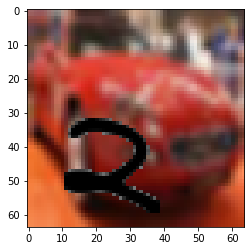

In [ ]:
plt.imshow(cifar_xt[5])

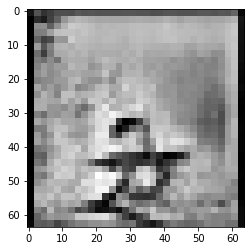

In [ ]:
#img2,_=invert(xt[5],hi_chars[12])
img2=np.array(Image.open('tst.jpg'),dtype=np.uint8)
img2=np.expand_dims(img2,axis=0)
plt.imshow(np.array(model(img2)[0],dtype=np.uint8).reshape(64,64),cmap='gray')